# ATLAS-Higgs machine learning challenge

First of all we load all necessary packages, i want to tackle this problem by using a Boosted Decision Tree (BDT)

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
from os import listdir
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier as DTR

## Loading and inspection of dataset

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train

,Index,Weight,Label,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,1000,0.538514,b,55.270143,36.798447,39.192581,85.793932,-999.000000,-999.000000,-999.000000,...,2.743088,245.105818,1,54.564685,-0.667353,-0.886142,-999.000000,-999.000000,-999.000000,55.045144
1,1001,1.733215,b,105.380268,78.492347,78.343361,0.758868,-999.000000,-999.000000,-999.000000,...,3.075594,81.092687,0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
2,1002,0.000461,s,138.666577,17.241167,99.917012,145.674537,3.720333,594.995269,-1.262204,...,-1.866072,373.532388,2,94.940989,3.335869,1.555474,84.874400,-0.373526,-0.316527,177.776898
3,1003,0.604536,b,78.107088,49.115916,57.776160,25.778405,-999.000000,-999.000000,-999.000000,...,-2.073460,108.824965,0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
4,1004,0.005721,s,125.043640,5.713137,88.206327,0.515929,-999.000000,-999.000000,-999.000000,...,-1.137978,65.167231,0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409114,410114,0.418760,b,81.080163,14.650106,46.853575,86.861358,0.417751,146.616974,1.005941,...,-0.639796,339.131966,2,116.253177,-0.822237,2.820299,48.362225,-1.226569,-1.154867,163.260318
409115,410115,0.005721,s,120.411602,21.271516,84.778729,33.679685,-999.000000,-999.000000,-999.000000,...,2.070996,129.261783,0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
409116,410116,0.757173,b,316.653931,82.747114,94.986028,209.502746,1.182966,167.401116,3.724037,...,2.045056,439.528969,2,208.328404,-1.432871,-1.073611,31.013383,-2.597883,-3.083196,238.692264
409117,410117,1.392630,b,-999.000000,82.710762,61.770338,14.332246,-999.000000,-999.000000,-999.000000,...,1.937316,154.300179,0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000


invalid entries (-999.0) have to be replaced by 0

In [4]:
def preprocess_dataframe(df):
    df.replace(-999.0,0,True)

In [5]:
preprocess_dataframe(df_train)
preprocess_dataframe(df_test)

For inspection, it's useful to distinguish between background and signal

In [6]:
df_background=df_train[df_train["Label"]=='b']
df_signal=df_train[df_train["Label"]=='s']

Now we divide the data into weights (w), fit parameters (X) and desired fit value (Y)

In [7]:
w=(df_train["Weight"]) # extract the weights for easy access later

X=(df_train.drop(columns=['Index','Weight','Label'])) # index, weight and label are not part of fit
cols = X.columns #this is going to be useful for inspection of data

Y=(df_train["Label"])
Y=Y.map({'s':1.0,'b':0.0}) # need to map this explicitly

First look at the properties (histograms) of signal and background distribution. Use the Kolomogorov-Smirnov score to rate the properties. This can be used in the hyper-parameter scan.

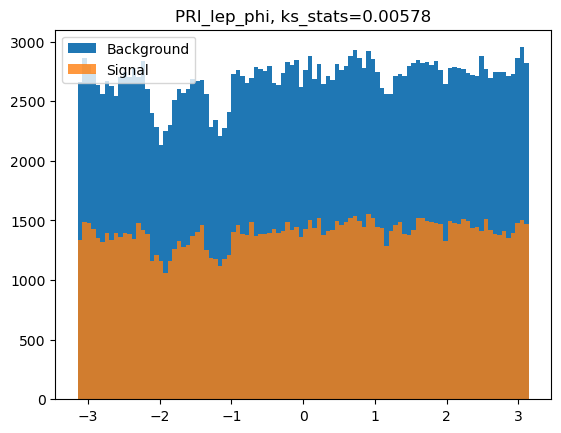

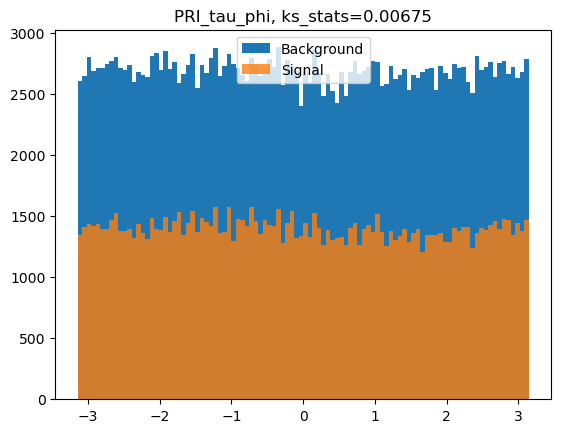

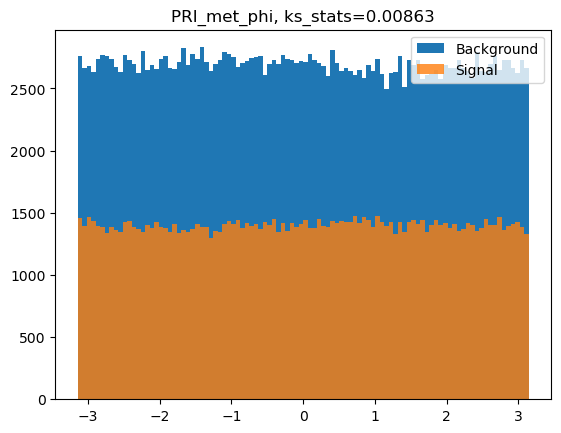

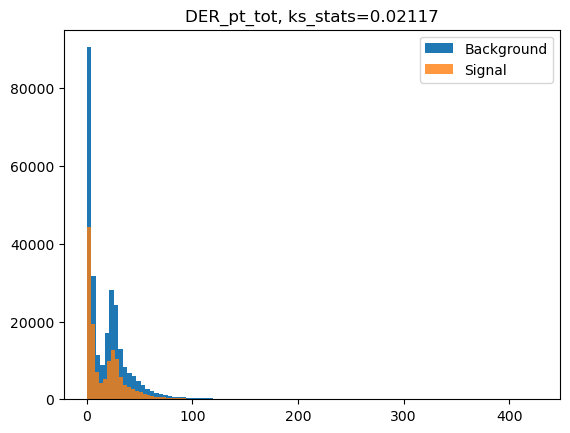

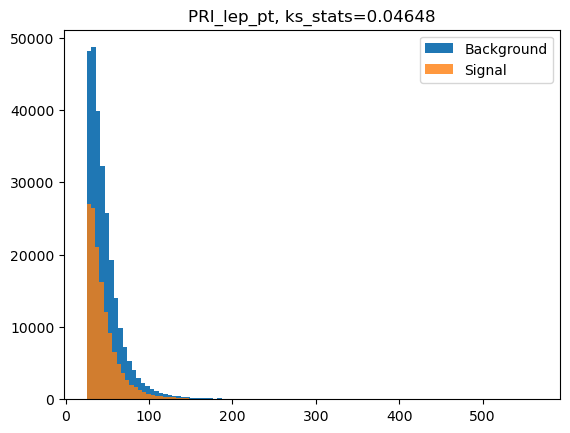

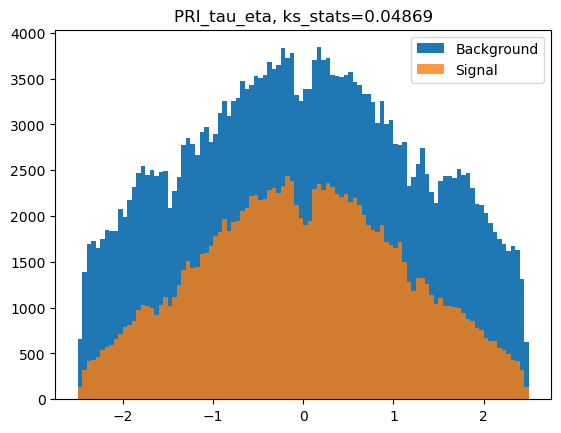

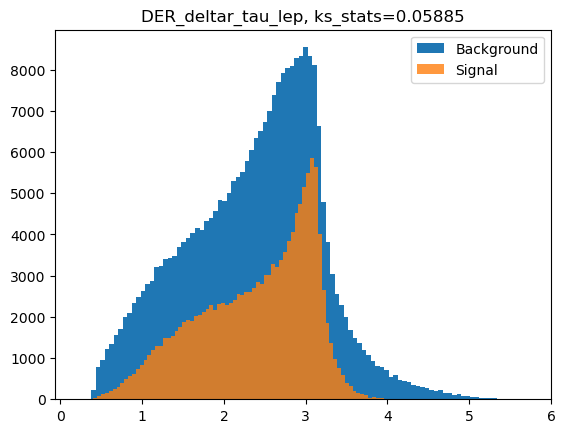

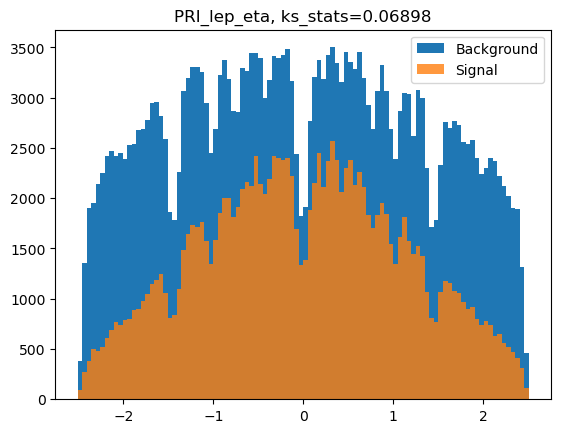

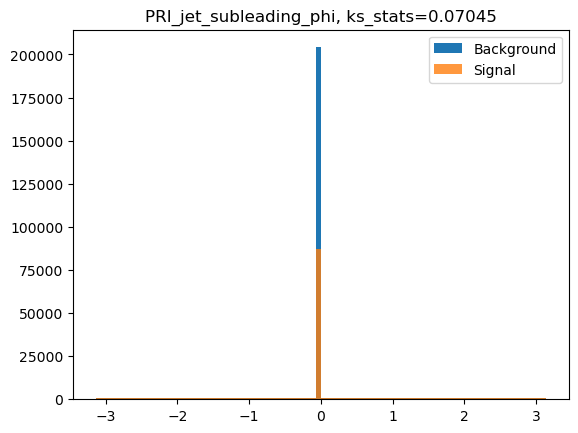

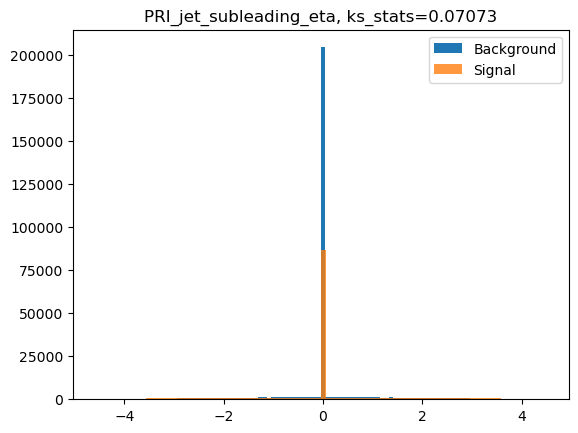

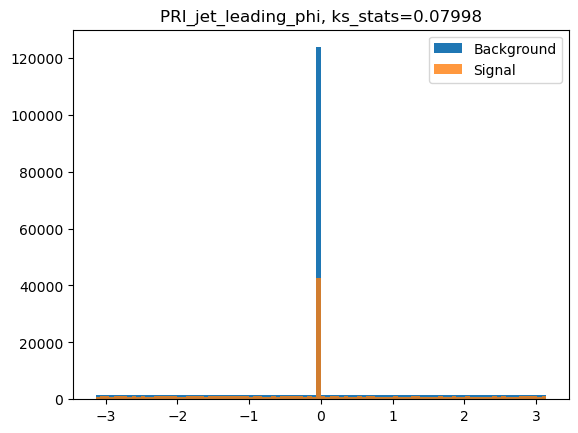

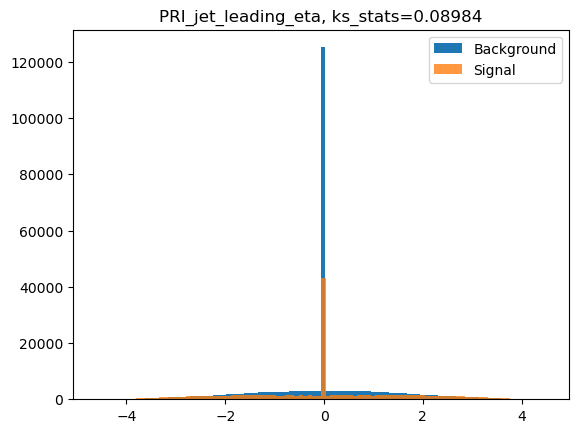

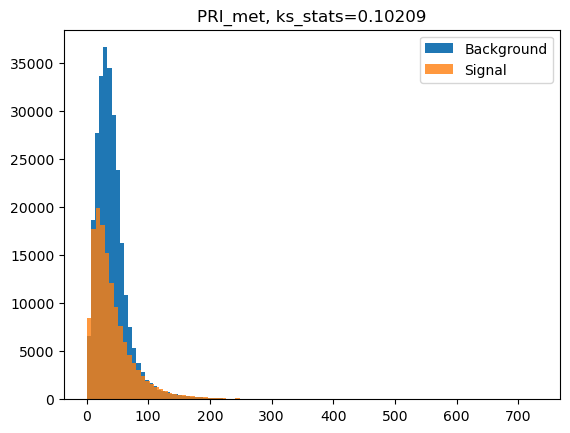

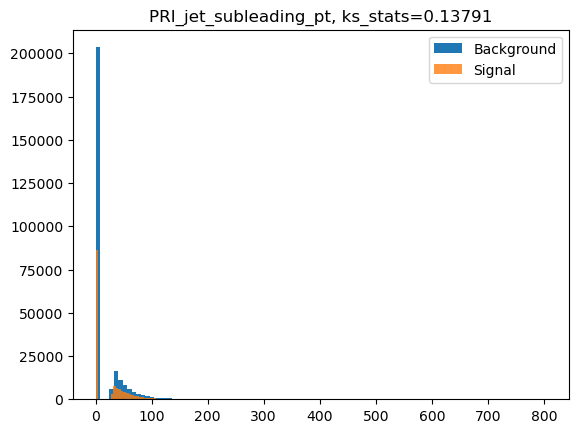

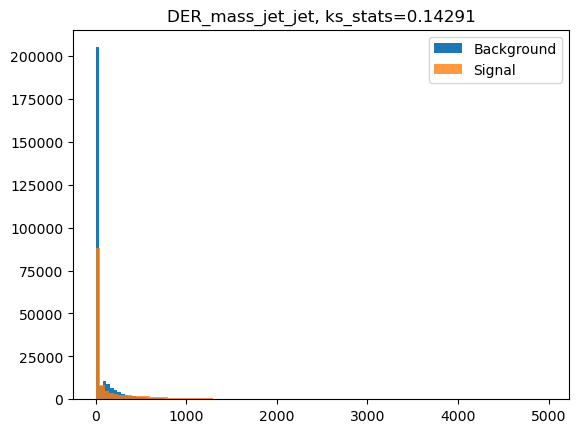

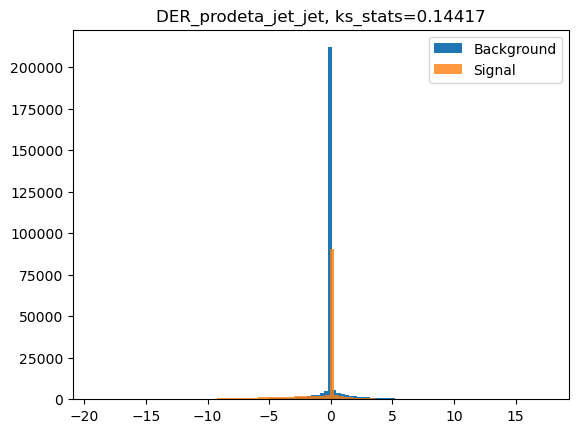

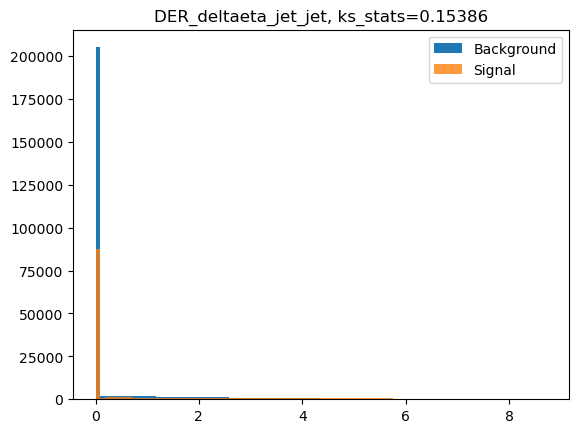

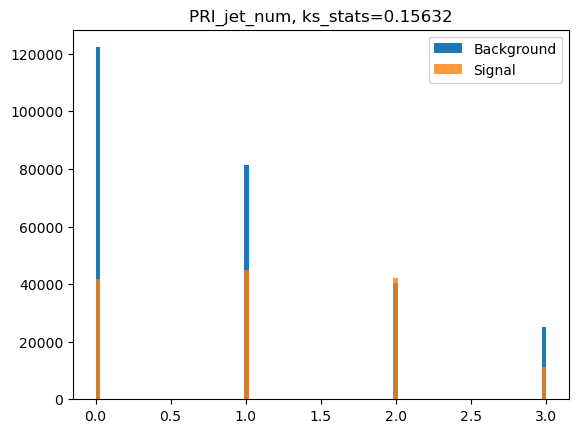

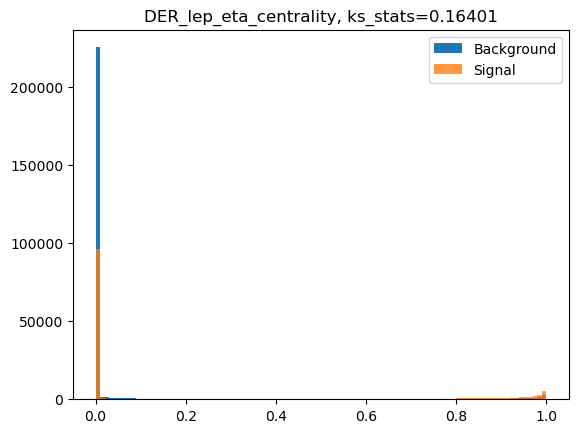

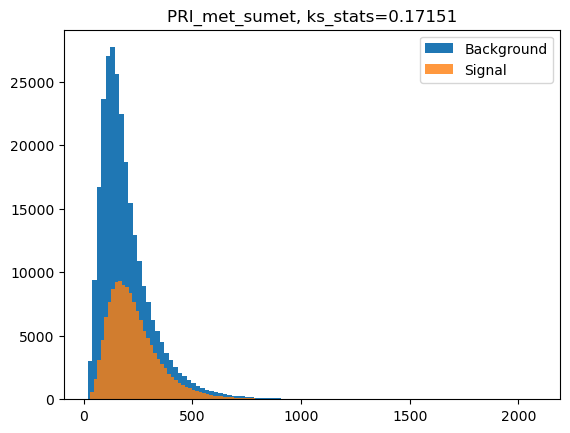

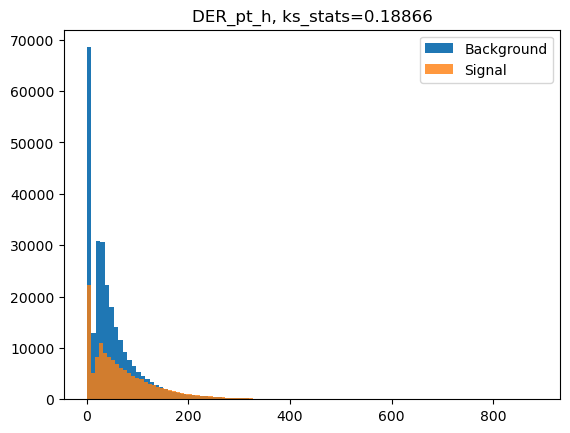

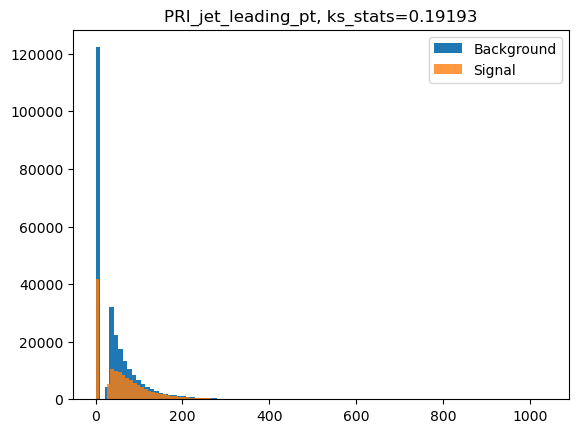

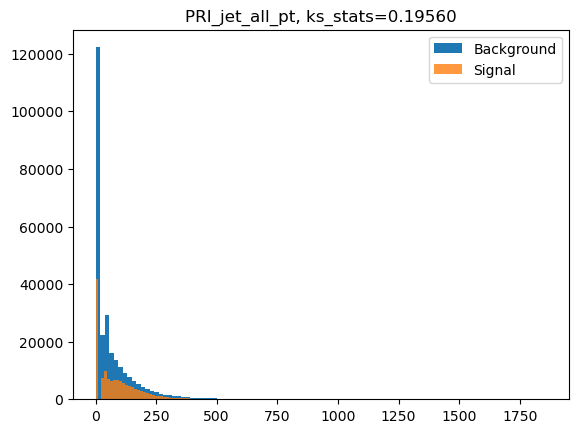

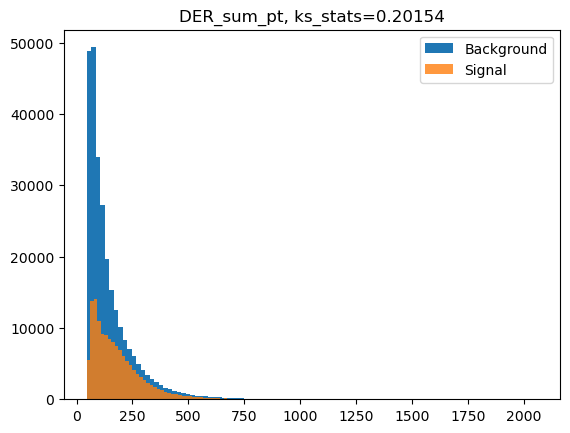

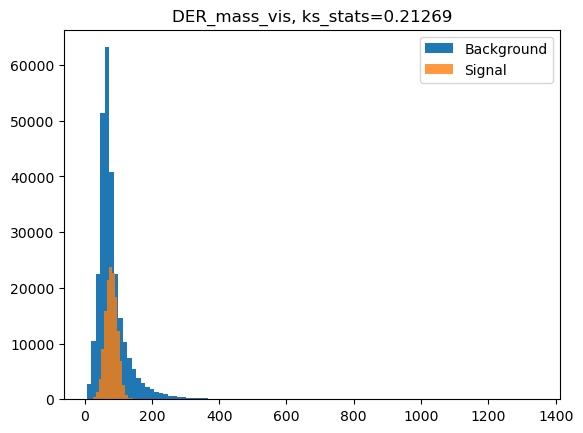

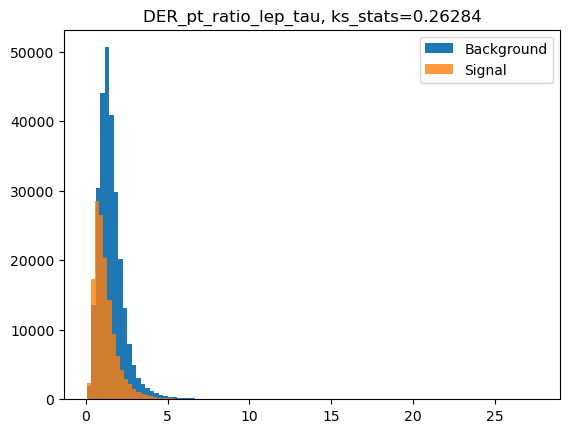

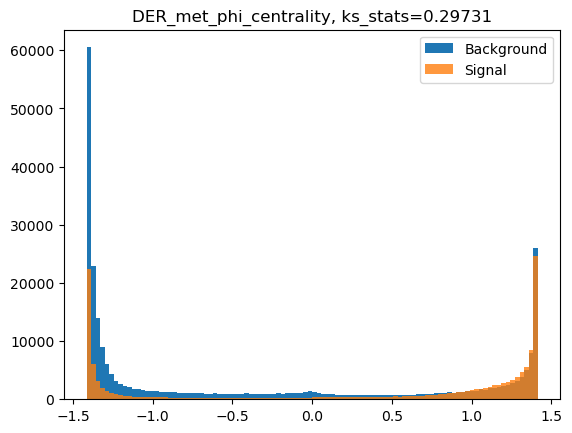

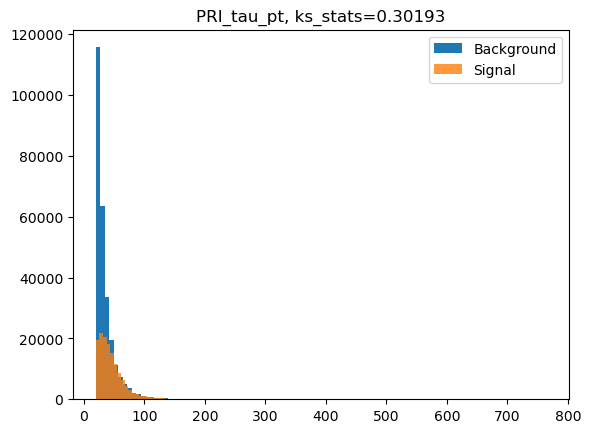

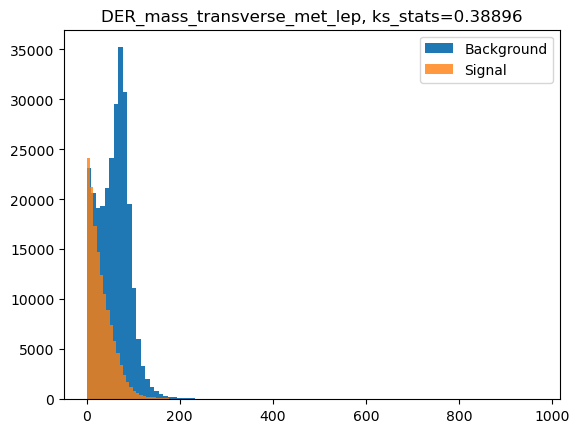

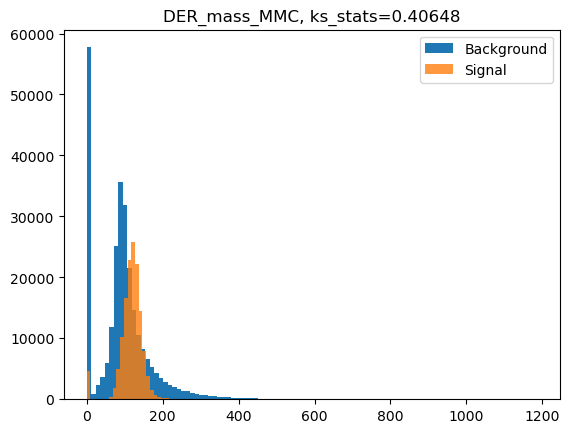

In [8]:
ks_stats=[]
ks_pvalues=[]
# use ks stats to rate properties and sort them
for col in cols:
    ks_stats.append(stats.ks_2samp(df_background[col],df_signal[col])[0])
    ks_pvalues.append(stats.ks_2samp(df_background[col],df_signal[col])[1])
cols_stats = np.array([cols, ks_stats]).T
sortedCols = cols_stats[cols_stats[:,1].argsort()]

#plot all properties in sorted order
for col, ks in sortedCols:
    plt.hist(df_background[col],bins=100,label="Background")
    plt.hist(df_signal[col],bins=100,alpha=0.8,label="Signal")
    plt.legend()
    plt.title("%s, ks_stats=%.5f"%(col, ks))
    plt.show()

now look at the data with respect to the length. For this calculate AMS score in dependence of the length of the data. This results in a monotonous function w.r.t length of the data. Thus the whole dataset is used.

In [9]:
def calc_AMS(y_pred,y_target,weights):
    target = y_target
    #if target[0]=='s' or target[0]=='b': target = y_target.map({'s':1.0,'b':0.0})
    br = 10.0
    sig = weights[target == 1] #weights for bckg and signal events 
    bgd = weights[target == 0] 
    annsig=y_pred[target == 1] #predictions for bckg and signal events
    annbgd=y_pred[target == 0]
    cutvals = np.quantile(annsig,np.linspace(0.,1.0,num=200))
    bestAMS,best_cutval= 0.0,0.0
    for cut in cutvals:
        s=sum(sig[annsig>cut])#true positive
        b=sum(bgd[annbgd>cut])#false positive
        AMS=math.sqrt( 2.0*( (s+b+br) * math.log(1+s/(b+br))-s) )#ams score
        if AMS>bestAMS: bestAMS, best_cutval = AMS, cut
    print("optimal cut value",best_cutval, "AMS=",bestAMS)
    return bestAMS,best_cutval

In [10]:
X=df_train[cols]
Y=(df_train["Label"])
Y=Y.map({'s':1.0,'b':0.0}) # need to map this explicitly
w=(df_train["Weight"]) # extract the weights for easy access later

X_train, X_test, Y_train, Y_test, w_train, w_test=train_test_split(X,Y,w,train_size=0.5,shuffle=False) #split data into training and testing samples
BDT=AdaBoostClassifier(base_estimator=DTR(max_depth=3),n_estimators=50,learning_rate=0.1) #create BDT with AdaBoostClassifier
BDT.fit(X_train, Y_train,w_train)
test_pred=BDT.predict_proba(X_test)[:,1] # need second column in prob. matrix for probability of signal
res=calc_AMS(test_pred,Y_test,w_test)# check the score




optimal cut value 0.31750169354781127 AMS= 1.5802148631575972


I now have a working classifier which already gives us a decent enough score. I will now try to maximize it using a hyperparameter scan.
    

## Model building and feature engineering
- number of input parameters
- params of base estimator
- params of AdaBoostClassifier

First, with the model thats already working okayish, lets look how many of the input parameters we really need

In [11]:
scores=[]
params=[30-i for i in range(20)]
for k in range(20): # this is an educated guess considering the plots and ks_stats score from before
    cut_sortedCols=sortedCols[sortedCols[:,1]>=sortedCols[k,1]]# keep only those parameter with higher score than 1st, 2nd, ...
    cols_split = cut_sortedCols[:,0]
    X=df_train[cols_split]
    Y=(df_train["Label"])
    Y=Y.map({'s':1.0,'b':0.0}) # need to map this explicitly
    
    X_train, X_test, Y_train, Y_test, w_train, w_test=train_test_split(X,Y,w,train_size=0.5,shuffle=False) #split data into training and testing samples
    BDT=AdaBoostClassifier(base_estimator=DTR(max_depth=3),n_estimators=50,learning_rate=0.1) #create BDT with AdaBoostClassifier
    BDT.fit(X_train, Y_train,w_train)
    test_pred=BDT.predict_proba(X_test)[:,1] # need second column in prob. matrix for probability of signal
    res=calc_AMS(test_pred,Y_test,w_test)# check the score
    scores.append(res[0])


optimal cut value 0.31750169354780977 AMS= 1.5802148631575972
optimal cut value 0.31750169354781005 AMS= 1.5802148631575972
optimal cut value 0.31750169354781027 AMS= 1.5802148631575972
optimal cut value 0.3175016935478102 AMS= 1.5802148631575972
optimal cut value 0.324021594855478 AMS= 1.5940649086392604
optimal cut value 0.3317931837229504 AMS= 1.597342651406359
optimal cut value 0.3293900394400671 AMS= 1.5917594963534802
optimal cut value 0.3217997519525568 AMS= 1.5789122458279217
optimal cut value 0.3170696078716813 AMS= 1.5669717199518503
optimal cut value 0.31706960787168026 AMS= 1.5669717199518503
optimal cut value 0.3170696078716808 AMS= 1.5669717199518503
optimal cut value 0.31706960787168065 AMS= 1.5669717199518503
optimal cut value 0.31937393164869 AMS= 1.5707993680857584
optimal cut value 0.3287940256994691 AMS= 1.5668390756555404
optimal cut value 0.32879402569946803 AMS= 1.5668390756555404
optimal cut value 0.32568852660880976 AMS= 1.570935265536155
optimal cut value 0.32

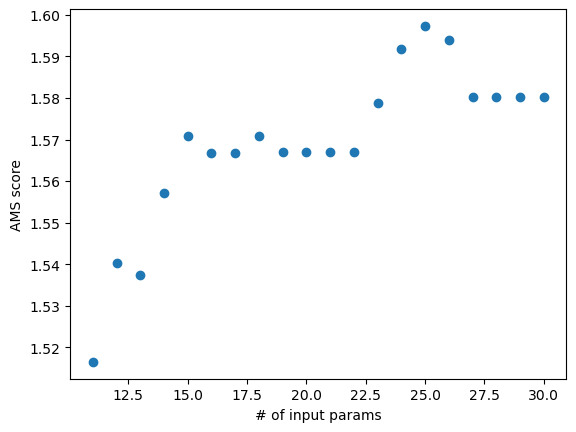

In [12]:
plt.plot(params,scores,'o')
plt.xlabel('# of input params')
plt.ylabel('AMS score')
plt.show()

It seems it is best to work with 25 input parameters, disregarding the first five (regarding their Kolmogorov-Smirnov score), this checks out with the plots from before. Now i will perform a hyperparameter-scan and try to maximize the score.

In [13]:
cut_sortedCols=sortedCols[sortedCols[:,1]>=sortedCols[5,1]]# keep only those parameter with higher score than 5th, see above
cols_split = cut_sortedCols[:,0]
X=df_train[cols_split]
Y=(df_train["Label"])
Y=Y.map({'s':1.0,'b':0.0}) # need to map this explicitly
w=(df_train["Weight"]) # extract the weights for easy access later

X_train, X_test, Y_train, Y_test, w_train, w_test=train_test_split(X,Y,w,train_size=0.5,shuffle=False) #split data into training and testing samples, INCLUDING WEIGHTS
def get_best_params():
    #first we will find the best params for our base estimator
    params = {
    'max_features' : [10,12,15,20,25],# max. no. of features to be considered
    'max_depth' : [10, 12, 15, 20], #maximum depth of decision tree
    'min_samples_split' : [200, 300, 500], #minimum samples that can be split at node
    'min_samples_leaf' : [200, 300, 500] #minimum samples at leaf node
    }
    clf=GridSearchCV(DTR(), params, verbose=True, n_jobs=-1)
    clf.fit(X_train, Y_train, sample_weight=w_train)
    return clf.best_params_
    
p=get_best_params()
print(p)
print("-----------------------------")


def get_best_n():
    scores=[]
    estimators=[20,50,100,150]
    for n in estimators:
        BDT=AdaBoostClassifier(base_estimator=DTR(**p),n_estimators=n,learning_rate=0.1) #create BDT with AdaBoostClassifier
        BDT.fit(X_train, Y_train,w_train)
        test_pred=BDT.predict_proba(X_test)[:,1] # need second column in prob. matrix for probability of signal
        scores.append(calc_AMS(test_pred,Y_test,w_test)[0])# check the score
    best_n=estimators[scores.index(max(scores))]
    return best_n
best_n=get_best_n()
print(best_n)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'max_depth': 20, 'max_features': 20, 'min_samples_leaf': 200, 'min_samples_split': 200}
-----------------------------
optimal cut value 0.1813940161639193 AMS= 1.772765219360759
optimal cut value 0.4832448904411566 AMS= 1.2209282300132571
optimal cut value 0.4968650973778113 AMS= 0.856475538525179
optimal cut value 0.49771928896184037 AMS= 0.8135886084679859
20


In [14]:
X=df_train[cols_split]
Y=(df_train["Label"])
Y=Y.map({'s':1.0,'b':0.0}) # need to map this explicitly
w=(df_train["Weight"]) # extract the weights for easy access later

X_train, X_test, Y_train, Y_test, w_train, w_test=train_test_split(X,Y,w,train_size=0.5,shuffle=False) #split data into training and testing samples, INCLUDING WEIGHTS

BDT_final=AdaBoostClassifier(base_estimator=DTR(**p),n_estimators=best_n,learning_rate=0.1) #create BDT with AdaBoostClassifier
BDT_final.fit(X_train, Y_train,w_train)
test_pred=BDT_final.predict_proba(X_test)[:,1] # need second column in prob. matrix for probability of signal
final_res=calc_AMS(test_pred,Y_test,w_test)
np.percentile(test_pred,85)#quick sanity check that the cut is reasonable
cutval=final_res[1]


optimal cut value 0.16564244555941746 AMS= 1.7600827494077644


In [15]:
##now train the BDT on the whole training set
X=df_train[cols_split]
Y=(df_train["Label"])
Y=Y.map({'s':1.0,'b':0.0}) # need to map this explicitly
w=(df_train["Weight"]) # extract the weights for easy access later


BDT_final.fit(X,Y,w)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20,
                                                         max_features=20,
                                                         min_samples_leaf=200,
                                                         min_samples_split=200),
                   learning_rate=0.1, n_estimators=20)

In [16]:
X_test=df_test[cols_split]

test_pred=BDT_final.predict_proba(X_test)[:,1]

df_test['prediction'] = test_pred
selected = df_test[df_test['prediction']>cutval]
print("selected",len(selected),"test events")
# create submission csv file
selected['Index'].to_csv("submission_krause_jakob.csv",index=False)

selected 68549 test events
